In [22]:
import rasterio as rio
from rasterio import mask
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling

import numpy as np

import boto3
import s3fs

from shapely import geometry
from functools import partial
import pyproj
from shapely.ops import transform

import re
import os 
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

import matplotlib.pyplot as plt
%matplotlib inline

# Analysis of Accuracy of Predictions

In [2]:
aws_session = boto3.Session(profile_name = 'esip')

**Scope**: Predictions from a single ASO collect from Tuolumne, 20180528. 

In [3]:
fs = s3fs.S3FileSystem(session = aws_session)
predictions =  [d.split('/')[1] for d in fs.ls('planet-snowcover-predictions') if re.match(".*20180528.*_clip", d)]

We'll pair these predictions with ASO.

In [4]:
with rio.Env(profile_name = 'esip'):
    aso_projected = rio.open("s3://planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary.tif")

In [45]:
aso_projected.name

's3://planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary.tif'

In [5]:
with rio.Env(profile_name = 'esip'): 
    p = rio.open("s3://planet-snowcover-predictions/{}/merged.tif".format(predictions[5]))

In [72]:
def crop_aso_mask(aso, pred):
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init='epsg:{}'.format(aso_projected.crs['init'].split(":")[1]))) # destination coordinate system
    masked_aso = mask.mask(aso_projected, [transform(project, geometry.Polygon.from_bounds(*pred.bounds))], crop=True)
    
    prof = aso.profile
    prof.update(
        driver = 'GTiff',
        transform = masked_aso[1],
        width = masked_aso[0].squeeze().shape[0],
        height = masked_aso[0].squeeze().shape[1]
    )
    
    fname = os.path.basename(aso_projected.name)
    print(fname)
    
    with rio.open("/tmp/masked_{}".format(fname), 'w', **prof) as f:
        f.write(masked_aso[0].squeeze(), 1)
        
    return rio.open("/tmp/masked_{}".format(fname))

In [74]:
a = crop_aso_mask(aso_projected, p)

ASO_3M_SD_USCATE_20180528_binary.tif


In [84]:
a.shape

(8467, 4388)

In [85]:
a_resamp = a.read(out_shape = p.shape, resampling = Resampling.bilinear)

In [92]:
pred_mask = (p.read().squeeze() == 1).astype(int)
aso_mask = (a_resamp.squeeze() == 1).astype(int)

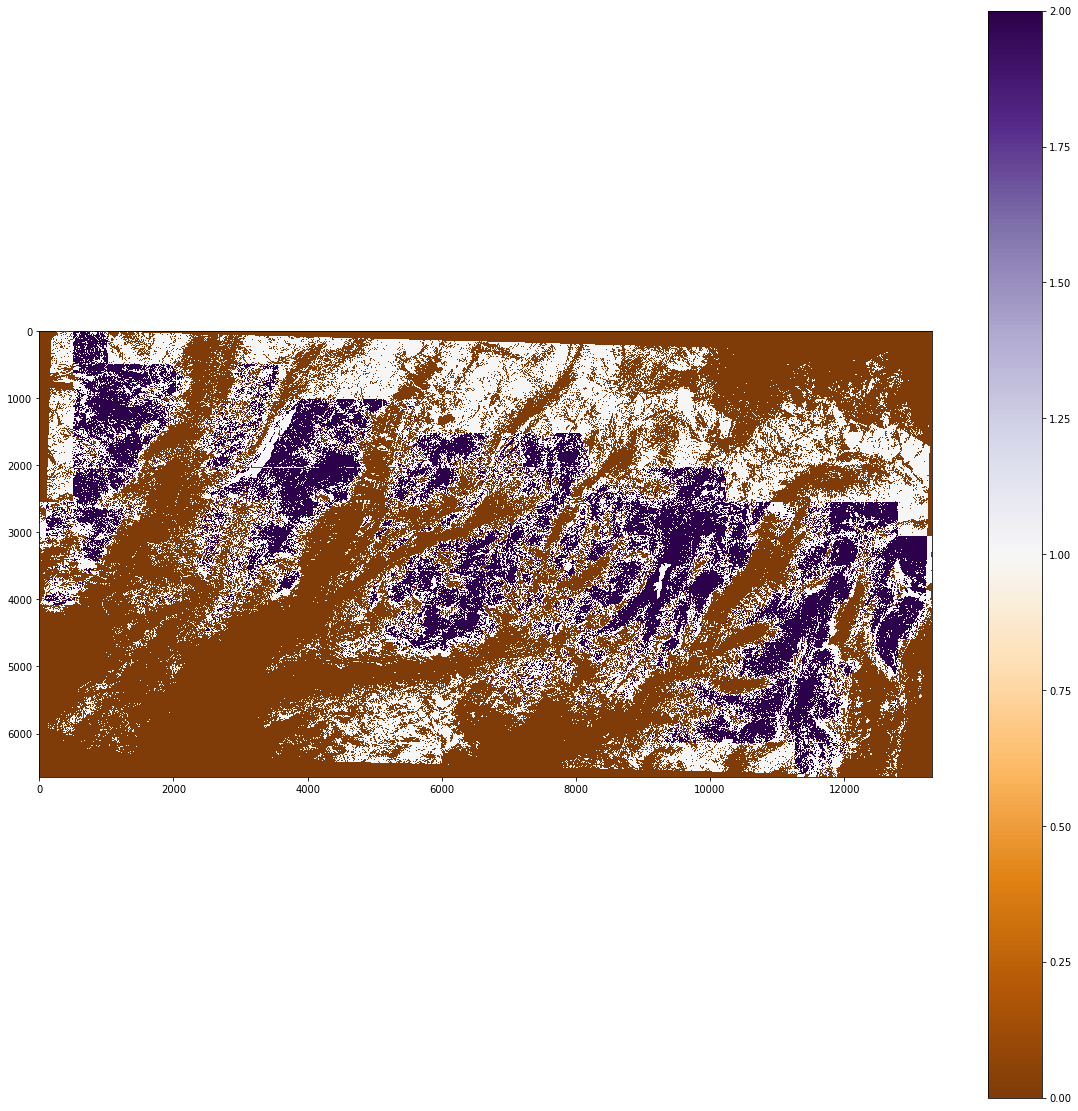

In [99]:
fig = plt.figure(figsize=(20,20))
plt.imshow(pred_mask + aso_mask, cmap='PuOr')
plt.colorbar()

In [24]:
aso_resamp = aso_projected.read(out_shape = p.shape, resampling = Resampling.nearest, )

KeyboardInterrupt: 

In [23]:
mask.mask(aso_resamp, [transform(project, geometry.Polygon.from_bounds(*p.bounds))], crop=True)

AttributeError: 'numpy.ndarray' object has no attribute 'nodata'

In [35]:
p.shape[0] / masked_aso[0].squeeze().shape[0]

1.51640838650866

In [37]:
masked_aso[0].shape

(1, 4388, 8467)